In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm     #acf,pacf图
from statsmodels.tsa.stattools import adfuller  #adf检验

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# R^2 goodness of fit calculation
def rsquare(fit,original):
    res_ydata  = np.array(original) - np.array(fit)
    ss_res     = np.sum(res_ydata**2)
    ss_tot     = np.sum((original - np.mean(original))**2)
    r_squared  = 1 - (ss_res / ss_tot)
    return r_squared

<AxesSubplot:xlabel='date'>

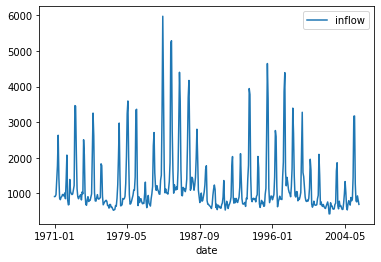

In [3]:
# Processing the original data
# powellin = pd.read_csv("Lake Powell 月度数据.csv",index_col='date')
powell = pd.read_csv("Lake Powell MonthlyIn (1971-2008).csv",index_col='date')
# Add the upper basin water usage data
upperusage = pd.read_csv("上下游用水数据 (Interim Report 1).csv",sep='\t',index_col="year")["upperwateruse"]
for i in range(0,powell.size):
    powell.iloc[i]+= (upperusage[int(powell.iloc[i].name.split("-")[0])]/12)

sep_index = 420
powellin = powell.iloc[:sep_index,:]
powell_predict = powell.iloc[sep_index:-1,:]
# print(powellin.head())
powellin.plot()

C:\Users\JHong\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


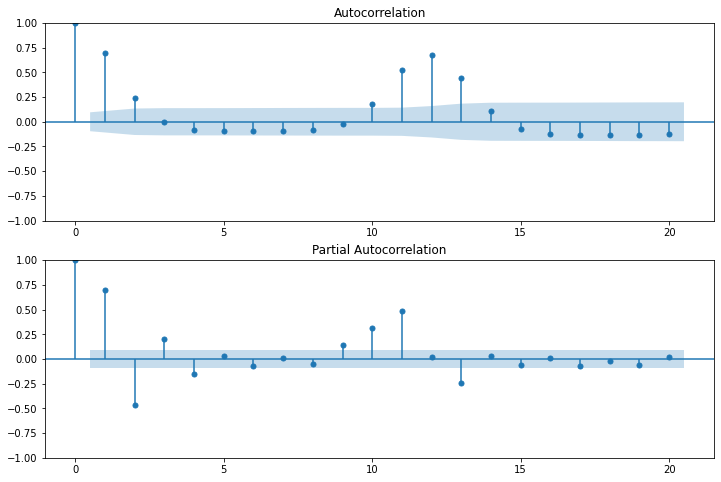

In [4]:
# ACF analysis

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(powellin,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(powellin,lags=20,ax=ax2)
plt.show()

In [5]:
# ADF analysis
# It can be seen from the results that the model data itself meets the stability requirements
temp = np.array(powellin["inflow"])
t = adfuller(temp)  # ADF检验
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

                                value
Test Statistic Value        -3.004562
p-value                      0.034471
Lags Used                          12
Number of Observations Used       407
Critical Value(1%)           -3.44652
Critical Value(5%)          -2.868668
Critical Value(10%)         -2.570567


C:\Users\JHong\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JHong\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JHong\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\JHong\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\JHong\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maxi

fitresult: 6039.932273569368 6100.064471351006 6063.7290912416465
R^2 is: 0.7913871207564861


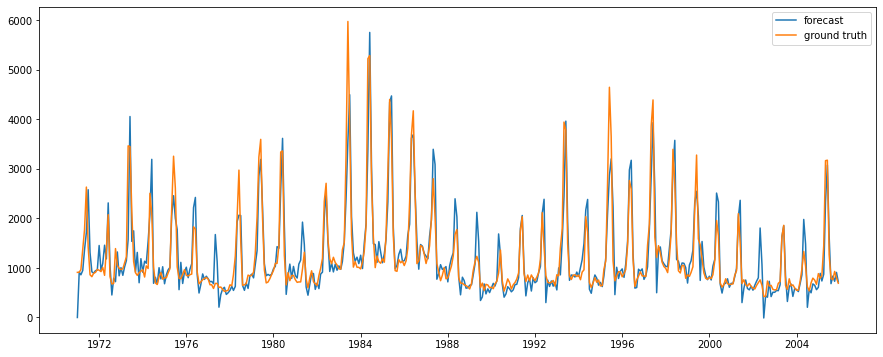

In [28]:
# SARIMAX fit
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(powellin, order=(8,1,4), seasonal_order=(1, 1, 1, 12))

result = model.fit()
print("fitresult:",result.aic,result.bic,result.hqic)

predict = result.predict()
# print(result.summary())

predictions = pd.Series(result.fittedvalues, copy=True)
print("R^2 is:",rsquare(predictions.tolist(),powellin["inflow"].tolist()))


prenew = predictions.to_frame()
prenew.reset_index(inplace=True)
prenew["date"] = pd.to_datetime(prenew["date"])
prenew = prenew.set_index("date",drop=True)

powellin.reset_index(inplace=True)
powellin["date"] = pd.to_datetime(powellin["date"])
powellin = powellin.set_index("date",drop=True)

plt.figure(figsize=(15, 6))
plt.plot(prenew,label="forecast")
plt.plot(powellin,label="ground truth")
plt.legend()
plt.show()

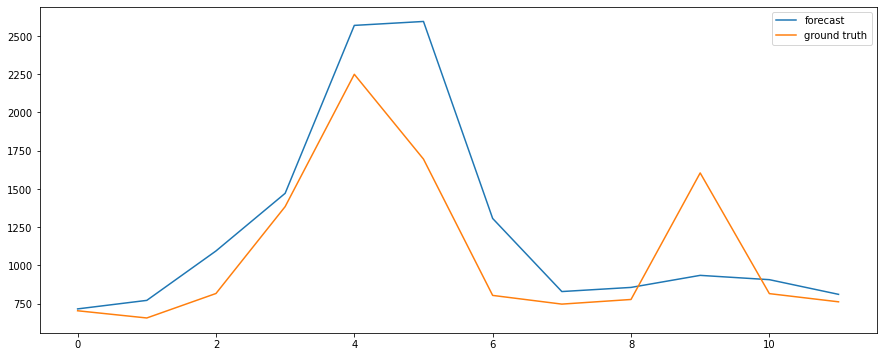

In [7]:
# Example Comparision of predictive capability
forecasted = result.forecast(12).tolist()
gt4predict = powell_predict["inflow"].tolist()[:12]

plt.figure(figsize=(15, 6))
plt.plot(forecasted,label="forecast")
plt.plot(gt4predict,label="ground truth")
plt.legend()
plt.show()

C:\Users\JHong\AppData\Local\Temp/ipykernel_28316/2774752850.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powellin["date"] = pd.to_datetime(powellin["date"])


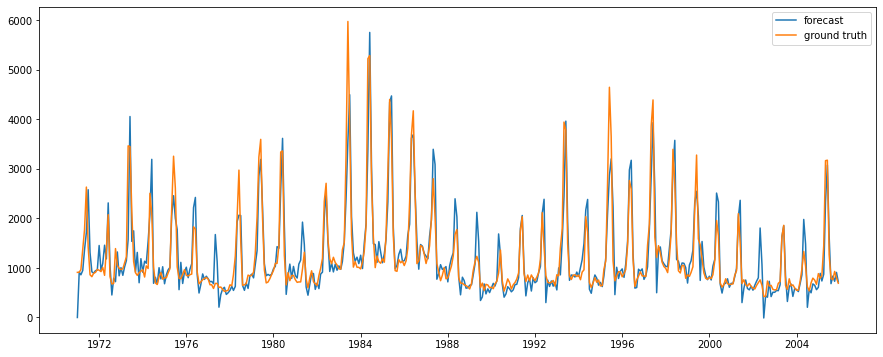

In [27]:
prenew = predictions.to_frame()
prenew.reset_index(inplace=True)
prenew["date"] = pd.to_datetime(prenew["date"])
prenew = prenew.set_index("date",drop=True)

powellin.reset_index(inplace=True)
powellin["date"] = pd.to_datetime(powellin["date"])
powellin = powellin.set_index("date",drop=True)

plt.figure(figsize=(15, 6))
plt.plot(prenew,label="forecast")
plt.plot(powellin,label="ground truth")
plt.legend()
plt.show()